Source notebook: https://github.com/statscol/clip-fine-tuning/blob/main/clip-fine-tuning.ipynb

## Fine-tuning Clip on PolyHaven dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [1]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
print("Torch version:", torch.__version__)

Torch version: 2.0.1


## Load Model & Data

In [2]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_json("dataset/polyhaven.json")
labels.head()

,name,tags,categories,caption
0,abandoned_bakery_1k,"[abandoned, empty, industrial, windows, bare, ...","[natural light, artificial light, urban, indoo...","[abandoned, empty, industrial, windows, bare, ..."
1,abandoned_church_1k,"[tree, autumn, church, abandoned, leaves]","[outdoor, nature, morning-afternoon, partly cl...","[tree, autumn, church, abandoned, leaves, outd..."
2,abandoned_construction_1k,"[brick, pillar, warehouse, rubble, abandoned, ...","[indoor, urban, natural light, medium contrast...","[brick, pillar, warehouse, rubble, abandoned, ..."
3,abandoned_factory_canteen_01_1k,"[hall, abandoned, fluorescent, industrial, bac...","[indoor, urban, low contrast, natural light]","[hall, abandoned, fluorescent, industrial, bac..."
4,abandoned_factory_canteen_02_1k,"[hall, abandoned, industrial, boxes, backplates]","[indoor, urban, natural light, medium contrast]","[hall, abandoned, industrial, boxes, backplate..."


In [3]:
torch.cuda.empty_cache()

In [4]:
model, preprocess = clip.load("ViT-B/32", jit=False)

In [5]:
train = labels
train.sort_values(by="name", ascending=True, inplace=True)
print(train.shape)


(477, 4)


In [7]:
#using datasets.ImageFolder makes loading images and preprocessing easier
image_folder = datasets.ImageFolder("dataset/polyhaven_clip",transform=preprocess)

In [8]:
## Create datasets

class PolyHaven(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption': " ".join(caption_idx)}
        
    def __len__(self):
        return len(self.captions)
    
dataset = PolyHaven(train.caption.values.tolist(), image_folder)
len(dataset)


477

In [12]:
## create dataloaders
BATCH_SIZE  =  8
TEST_SPLIT  = .2
RANDOM_SEED = 42

dataset_size = train.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

tr_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
ts_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

In [13]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS = 32
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Train Loop and validation

In [14]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

model.to(DEVICE)

## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()


def validate(test_dl):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        img_batch=data['image'].to(DEVICE)
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss


def train_model(n_epochs,train_dataloader,checkpoint_path:str="./clip_checkpoints"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()
        for step,data in enumerate(train_dataloader,1):
            
            optimizer.zero_grad()
            
            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            scheduler.step() ##per step scheduler
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")
            
        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(ts_dl)
        history['val_loss'].append(val_metrics)

        if val_metrics<best_score:
            print("Better score reached, saving checkpoint...")
            if os.path.exists(Path(checkpoint_path)/"clip_finetuned_polyhaven.pt"):
                os.remove(Path(checkpoint_path)/"clip_finetuned_polyhaven.pt")
            best_score=val_metrics
            torch.save(model.state_dict(), Path(checkpoint_path)/"clip_finetuned_polyhaven.pt")
            
    return history
            

results=train_model(N_EPOCHS,tr_dl)

Using cuda:0 for training


  0%|          | 0/1 [00:00<?, ?it/s]

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.371
Better score reached, saving checkpoint...


https://github.com/openai/CLIP/issues/83

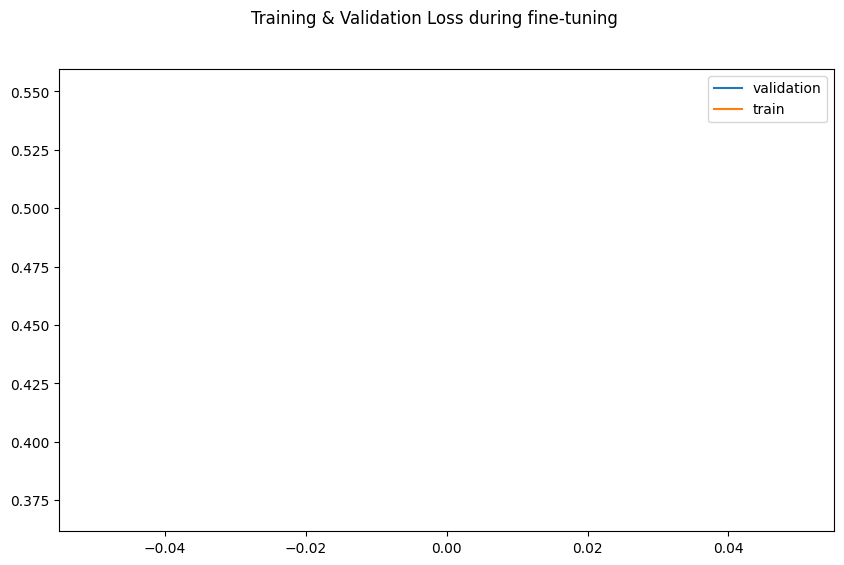

In [15]:
## lets see loss
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");